In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import os
try:
    import cv2
    print("OpenCV (cv2) imported successfully")
except ImportError:
    !pip install opencv-python-headless
    import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random

OpenCV (cv2) imported successfully


In [ ]:
# Download dataset
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
base_path = os.path.join(path, 'leapGestRecog')  # Correct path
print("Path to dataset files:", base_path)

Path to dataset files: /kaggle/input/leapgestrecog/leapGestRecog


In [ ]:
# Load dataset
images = []
labels = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                for img in os.listdir(subfolder_path):
                    if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(subfolder_path, img)
                        images.append(img_path)
                        labels.append(subfolder)

In [ ]:
# Create DataFrame
df = pd.DataFrame({'images': images, 'labels': labels})

# Encode labels
le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])
y = to_categorical(df['labels'])

print(f"Loaded {len(images)} images with {len(np.unique(labels))} unique labels.")
print("Unique labels:", sorted(np.unique(labels)))


Loaded 20000 images with 10 unique labels.
Unique labels: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [ ]:
img_size = (64, 64)
x = []

for img_path in df['images']:
    try:
        img = Image.open(img_path)
        img = img.convert('RGB')  # Convert to RGB
        img_resized = img.resize(img_size)
        img_array = np.array(img_resized) / 255.0  # Normalize
        x.append(img_array)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

x = np.array(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")


Training data shape: (16000, 64, 64, 3)
Testing data shape: (4000, 64, 64, 3)


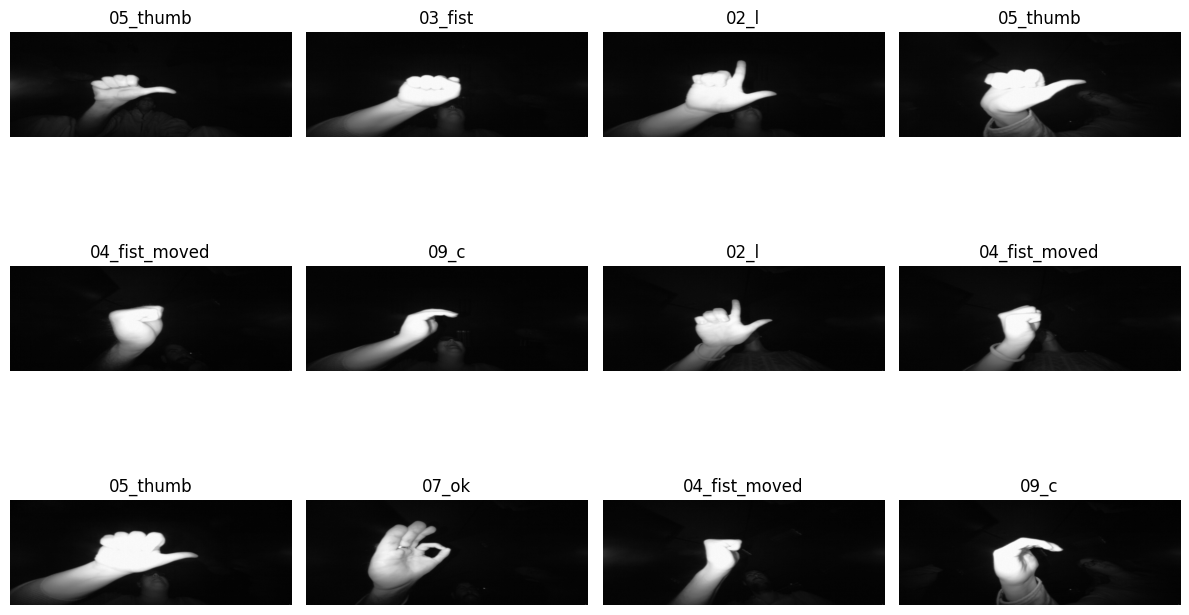

In [ ]:
# Visualize random images (inspired by reference code)
random_indices = random.sample(range(len(images)), 12)
random_images = [images[i] for i in random_indices]
random_labels = [labels[i] for i in random_indices]
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.flatten()
for idx, (img_path, label) in enumerate(zip(random_images, random_labels)):
    img = Image.open(img_path)
    img_array = np.array(img)
    axes[idx].imshow(img_array, cmap='gray')  # Grayscale for visualization
    axes[idx].set_title(label)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(x_train, y_train, epochs=10, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5721 - loss: 1.4500 - val_accuracy: 0.7365 - val_loss: 0.8957
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9348 - loss: 0.1921 - val_accuracy: 0.9970 - val_loss: 0.0089
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9627 - loss: 0.1094 - val_accuracy: 0.9980 - val_loss: 0.0064
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9737 - loss: 0.0804 - val_accuracy: 0.9948 - val_loss: 0.0238
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9746 - loss: 0.0826 - val_accuracy: 0.9980 - val_loss: 0.0075
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9862 - loss: 0.0469 - val_accuracy: 0.9910 - val_loss: 0.0312
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0064
Test Accuracy: 0.9980


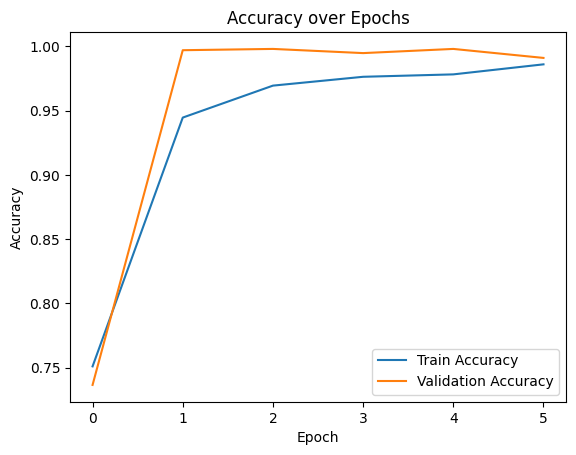

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


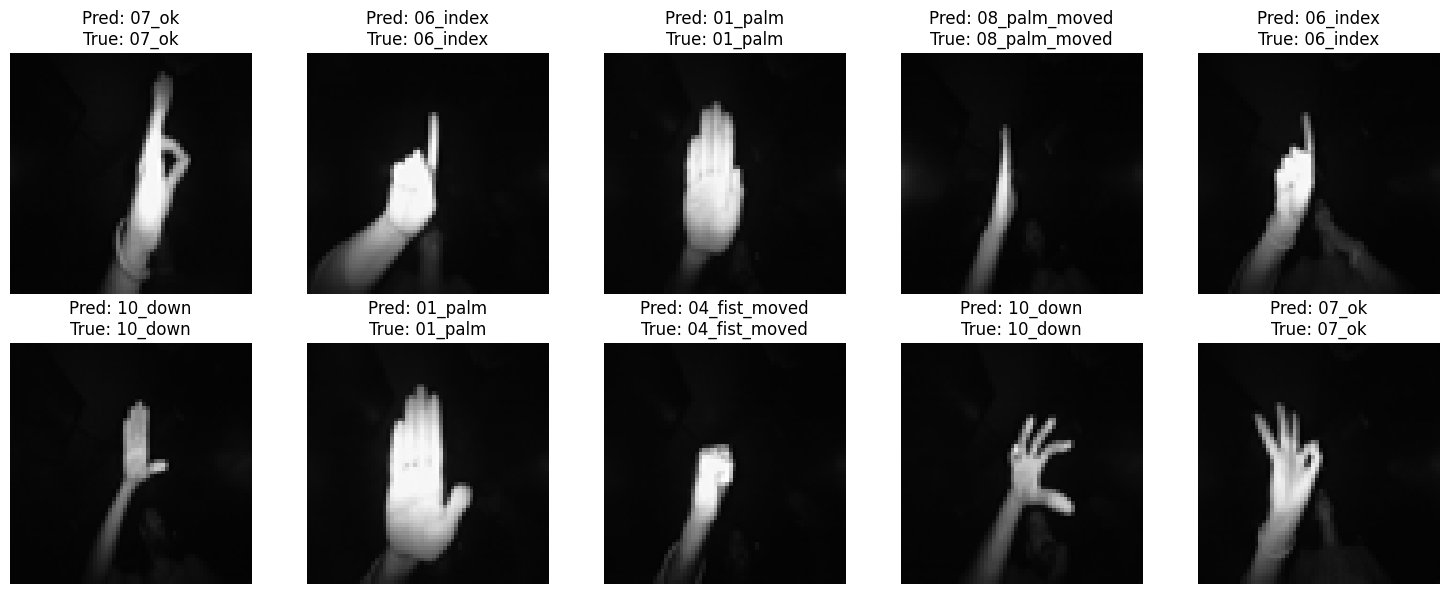

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
random_indices = random.sample(range(len(x_test)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    img = x_test[idx]
    pred_label = le.inverse_transform([predicted_classes[idx]])[0]
    true_label = le.inverse_transform([true_classes[idx]])[0]
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {pred_label}\nTrue: {true_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 1000x800 with 0 Axes>

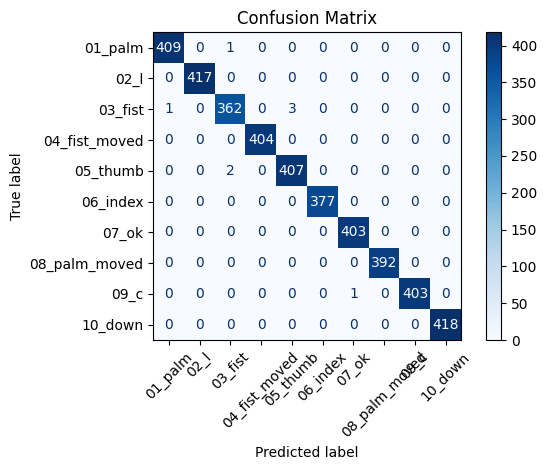

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       410
         02_l       1.00      1.00      1.00       417
      03_fist       0.99      0.99      0.99       366
04_fist_moved       1.00      1.00      1.00       404
     05_thumb       0.99      1.00      0.99       409
     06_index       1.00      1.00      1.00       377
        07_ok       1.00      1.00      1.00       403
08_palm_moved       1.00      1.00      1.00       392
         09_c       1.00      1.00      1.00       404
      10_down       1.00      1.00      1.00       418

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=le.classes_))

In [ ]:
model.save('gesture_recognition_model.h5')
print("Model saved as 'gesture_recognition_model.h5'")
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("LabelEncoder saved as 'label_encoder.pkl'")

Model saved as 'gesture_recognition_model.h5'
LabelEncoder saved as 'label_encoder.pkl'


In [ ]:
from google.colab import files
files.download('gesture_recognition_model.h5')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>